GloVe Download  
https://nlp.stanford.edu/projects/glove/

Using Glove Embeddings in Pytorch  
https://www.kaggle.com/kuldeep7688/simple-rnn-using-glove-embeddings-in-pytorch

Torchtext  
https://torchtext.readthedocs.io/en/latest/examples.html

### Import Libraries

In [1]:
import nltk
from nltk.corpus import brown

import seaborn as sns
import matplotlib.pyplot as plt

import time
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import spacy
import numpy as np

import pyprind
# For displaying how much time left

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline  

# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

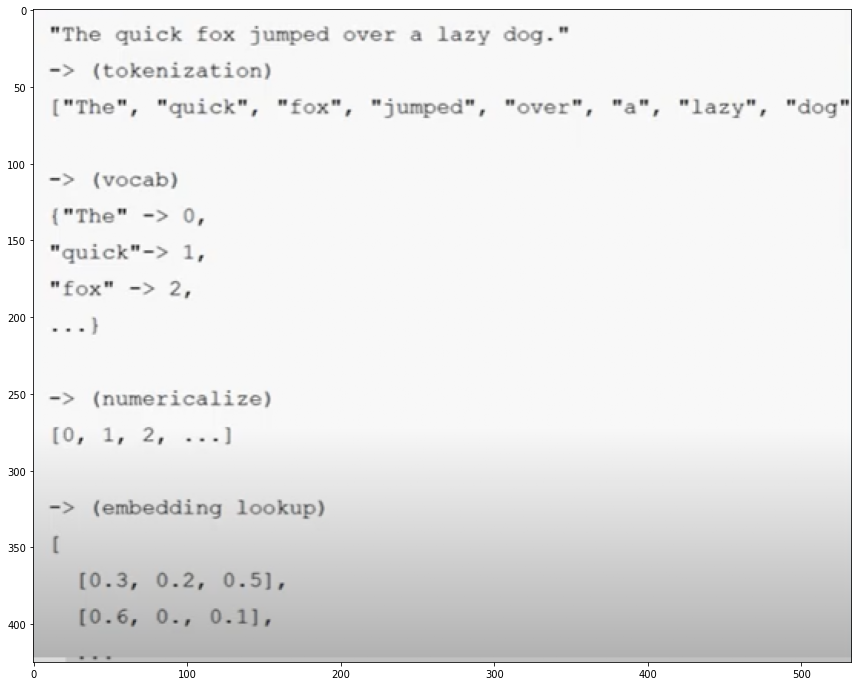

In [2]:
def showImage(x):    
    plt.figure(figsize=(20,12))
    img = mpimg.imread(str(x) +  '.PNG')
    plt.imshow(img)
showImage(1)


### Import Corpus
* From Brown Corpus
* Final Output: Training Data and Testing Data in following format:

[(['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN']),  
 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN'])]

In [3]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [4]:
taggedWords = nltk.corpus.brown.tagged_words(tagset='universal', categories=['news', 'editorial', 'reviews'])
taggedWords

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [5]:
tagFrequency = nltk.FreqDist(tag for (word, tag) in taggedWords)
tagFrequency = list(tagFrequency.items())
tagFrequency

[('DET', 23525),
 ('NOUN', 56352),
 ('ADJ', 15218),
 ('VERB', 29773),
 ('ADP', 24800),
 ('.', 24381),
 ('ADV', 8429),
 ('CONJ', 6032),
 ('PRT', 4670),
 ('PRON', 6072),
 ('NUM', 3365),
 ('X', 245)]

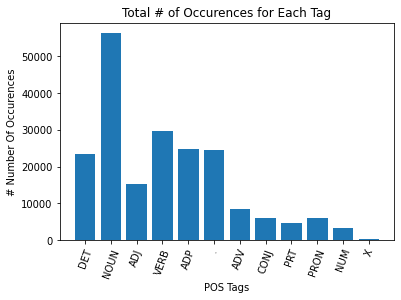

In [6]:
plt.bar(range(len(tagFrequency)), [val[1] for val in tagFrequency], align='center')
plt.xticks(range(len(tagFrequency)), [val[0] for val in tagFrequency])
plt.xticks(rotation=70)
plt.xlabel("POS Tags")
plt.ylabel("# Number Of Occurences")
plt.title("Total # of Occurences for Each Tag")
plt.show()

In [7]:
States = [tag[0] for tag in tagFrequency]
print(States)

['DET', 'NOUN', 'ADJ', 'VERB', 'ADP', '.', 'ADV', 'CONJ', 'PRT', 'PRON', 'NUM', 'X']


In [8]:
len(nltk.corpus.brown.tagged_sents(tagset='universal', categories=['news', 'editorial', 'reviews']))

9371

In [9]:
taggedSents = nltk.corpus.brown.tagged_sents(tagset='universal', categories=['news', 'editorial', 'reviews'])
taggedSents[:5]

[[('The', 'DET'),
  ('Fulton', 'NOUN'),
  ('County', 'NOUN'),
  ('Grand', 'ADJ'),
  ('Jury', 'NOUN'),
  ('said', 'VERB'),
  ('Friday', 'NOUN'),
  ('an', 'DET'),
  ('investigation', 'NOUN'),
  ('of', 'ADP'),
  ("Atlanta's", 'NOUN'),
  ('recent', 'ADJ'),
  ('primary', 'NOUN'),
  ('election', 'NOUN'),
  ('produced', 'VERB'),
  ('``', '.'),
  ('no', 'DET'),
  ('evidence', 'NOUN'),
  ("''", '.'),
  ('that', 'ADP'),
  ('any', 'DET'),
  ('irregularities', 'NOUN'),
  ('took', 'VERB'),
  ('place', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('jury', 'NOUN'),
  ('further', 'ADV'),
  ('said', 'VERB'),
  ('in', 'ADP'),
  ('term-end', 'NOUN'),
  ('presentments', 'NOUN'),
  ('that', 'ADP'),
  ('the', 'DET'),
  ('City', 'NOUN'),
  ('Executive', 'ADJ'),
  ('Committee', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('had', 'VERB'),
  ('over-all', 'ADJ'),
  ('charge', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('election', 'NOUN'),
  (',', '.'),
  ('``', '.'),
  ('deserves', 'VERB'),
  ('the', 'DET'),

In [10]:
# Checking if last sentence is equal to the words of last entry of list 
taggedSents[-1] == taggedWords[-(len(taggedSents[-1])):]

True

In [11]:
taggedSents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [12]:
trainingData, testingData = [], []

for index, sentence in enumerate(taggedSents):
        w, t = map(list, zip(*sentence))
        w = ' '.join(w).lower().split()
        if index <= int(0.8 * len(taggedSents)):
            trainingData.append({'Text': w, 'Tags': t})
        else:
            testingData.append({'Text': w, 'Tags': t})

with open('./data/trainingData.json', 'w') as f:
    for t in trainingData:
        json.dump(t, f)
        f.write('\n')
            
with open('./data/testingData.json', 'w') as f:
    for t in testingData:
        json.dump(t,f)
        f.write('\n')
        
print(len(trainingData), len(testingData))            

7497 1874


### BUILD VOCAB
https://torchtext.readthedocs.io/en/latest/data.html#torchtext.data.Field.build_vocab

classtorchtext.data.Field(sequential=True, use_vocab=True, init_token=None, eos_token=None, fix_length=None, dtype=torch.int64, preprocessing=None, postprocessing=None, lower=False, tokenize=None, tokenizer_language='en', include_lengths=False, batch_first=False, pad_token='<pad>', unk_token='<unk>', pad_first=False, truncate_first=False, stop_words=None, is_target=False)

In [13]:
# spacy_en = spacy.load('en')
# nltk.download('punkt')

def tokenize(text):
#     return [tok.text for tok in speacy.en(text)]
    return lambda x: x.split()
#     return [tok for tok in nltk.word_tokenize(text)]
#    nltk.word_tokenize('Hi I am a police officer')

In [14]:
TEXT = Field(sequential=True,)
TAGS = Field(sequential=True, unk_token = None,)

fields = {'Text': ('text', TEXT), 'Tags': ('tags', TAGS)}
# fields = (('Text', TEXT),('Tags', TAGS))
fields

{'Text': ('text', <torchtext.legacy.data.field.Field at 0x19b33b412b0>),
 'Tags': ('tags', <torchtext.legacy.data.field.Field at 0x19b33b41130>)}

In [15]:
train_data, test_data = TabularDataset.splits(
                                path = 'data',
                                train = 'trainingData.json',
                                test = 'testingData.json',
                                format = 'json',
                                fields = fields
)

In [16]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 7497
Number of testing examples: 1874


In [17]:
vars(train_data.examples[0])

{'text': ['the',
  'fulton',
  'county',
  'grand',
  'jury',
  'said',
  'friday',
  'an',
  'investigation',
  'of',
  "atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 'tags': ['DET',
  'NOUN',
  'NOUN',
  'ADJ',
  'NOUN',
  'VERB',
  'NOUN',
  'DET',
  'NOUN',
  'ADP',
  'NOUN',
  'ADJ',
  'NOUN',
  'NOUN',
  'VERB',
  '.',
  'DET',
  'NOUN',
  '.',
  'ADP',
  'DET',
  'NOUN',
  'VERB',
  'NOUN',
  '.']}

In [18]:
# unk_init is used to initialize the token embeddings which are 
# not in the pre-trained embedding vocabulary. By default this sets 
# those embeddings to zeros, however it is better to not have them 
# all initialized to the same value, so we initialize them from a Normal/Gaussian distribution.


TEXT.build_vocab(train_data, 
                 min_freq = 2,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
TAGS.build_vocab(train_data)

In [19]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in TAGS vocabulary: {len(TAGS.vocab)}")

Unique tokens in TEXT vocabulary: 8410
Unique tokens in TAGS vocabulary: 13


In [20]:
print(TAGS.vocab.itos)

['<pad>', 'NOUN', 'VERB', 'ADP', '.', 'DET', 'ADJ', 'ADV', 'PRON', 'CONJ', 'PRT', 'NUM', 'X']


In [21]:
print(TEXT.vocab.freqs.most_common(10))

[('the', 10187), (',', 7865), ('.', 6405), ('of', 4765), ('to', 3670), ('and', 3480), ('a', 3251), ('in', 3061), ('for', 1499), ('is', 1459)]


In [22]:
print(TAGS.vocab.freqs.most_common())

[('NOUN', 45234), ('VERB', 23915), ('ADP', 19665), ('.', 18733), ('DET', 18500), ('ADJ', 11522), ('ADV', 6228), ('PRON', 4704), ('CONJ', 4499), ('PRT', 3741), ('NUM', 2854), ('X', 128)]


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [44]:
BATCH_SIZE = 128
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
#     sort_key = lambda x: x.text,
#     sort = True,
    sort=False,
    batch_size = BATCH_SIZE,
    device = device)

In [25]:
batch = next(iter(train_iterator))
batch


[torchtext.legacy.data.batch.Batch of size 128]
	[.text]:[torch.cuda.LongTensor of size 67x128 (GPU 0)]
	[.tags]:[torch.cuda.LongTensor of size 67x128 (GPU 0)]

In [26]:
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, 
                 n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        #pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        
        #outputs holds the backward and forward hidden states in the final layer
        #hidden and cell are the backward and forward hidden and cell states at the final time-step
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]
        
        #we use our outputs to make a prediction of what the tag should be
        predictions = self.fc(self.dropout(outputs))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

### Training Model

In [27]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(TAGS.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [28]:
model = BiLSTMPOSTagger(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

In [29]:
# We initialize the weights from a simple Normal distribution. 
# Again, there may be a better initialization scheme for this model and dataset.

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

BiLSTMPOSTagger(
  (embedding): Embedding(8410, 100, padding_idx=1)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=13, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [30]:
# a small function to tell us how many parameters are in our model. 
# Useful for comparing different models.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,475,125 trainable parameters


In [31]:
# We'll now initialize our model's embedding layer 
# with the pre-trained embedding values we loaded earlier.

# This is done by getting them from the vocab's .vectors attribute 
# and then performing a .copy to overwrite the embedding layer's 
# current weights


pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([8410, 100])


In [32]:
# It's common to initialize the embedding of the pad token to all zeros.
# This, along with setting the padding_idx in the model's embedding layer, 
# means that the embedding should always output a tensor full of zeros 
# when a pad token is input.

model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.1743,  0.1134,  0.1948,  ...,  0.0231,  0.0855,  0.0399],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0069, -0.1004,  0.0654,  ...,  0.0321,  0.0766,  0.0046],
        ...,
        [-0.0152, -0.0308,  0.0405,  ..., -0.0774,  0.0692,  0.1125],
        [-0.2341, -0.0146,  0.0547,  ...,  0.0682, -0.1279, -0.1061],
        [ 0.1337, -0.0364,  0.0655,  ...,  0.0132,  0.2511,  0.1818]])


In [33]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.3632,  1.7402,  1.6276,  ...,  0.0539, -0.2205,  2.7822],
        [-2.0056,  1.3756, -1.7954,  ...,  0.2378, -0.0736,  1.0642],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0091,  0.2810,  0.7356,  ..., -0.7508,  0.8967, -0.7631],
        [ 0.3338, -0.4627, -0.6622,  ...,  0.1423, -0.2750,  0.0502],
        [ 0.9511, -0.4373,  0.4993,  ...,  0.6739,  0.2300,  0.4647]])

We define our loss function, cross-entropy loss.

Even though we have no `<unk>` tokens within our tag vocab, we still have `<pad>` tokens. This is because all sentences within a batch need to be the same size. However, we don't want to calculate the loss when the target is a `<pad>` token as we aren't training our model to recognize padding tokens.

We handle this by setting the `ignore_index` in our loss function to the index of the padding token in our tag vocabularye define our loss function, cross-entropy loss.

In [34]:
# We then define our optimizer, used to update our parameters w.r.t. 
# their gradients. We use Adam with the default learning rate.
optimizer = optim.Adam(model.parameters())


TAG_PAD_IDX = TAGS.vocab.stoi[TAGS.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [35]:
# place our model and loss function on our GPU
model = model.to(device)
criterion = criterion.to(device)

We will be using the loss value between our predicted and actual tags to train the network, but ideally we'd like a more interpretable way to see how well our model is doing - accuracy.

The issue is that we don't want to calculate accuracy over the `<pad>` tokens as we aren't interested in predicting them.

The function below only calculates accuracy over non-padded tokens. `non_pad_elements` is a tensor containing the indices of the non-pad tokens within an input batch. We then compare the predictions of those elements with the labels to get a count of how many predictions were correct. We then divide this by the number of non-pad elements to get our accuracy value over the batch.

In [36]:
def categorical_accuracy(preds, y, tag_pad_idx):

    # get the index of the max probability
    max_preds = preds.argmax(dim = 1, keepdim = True) 
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [37]:
# Next, we have a small function that tells us how long an epoch takes.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We first set the model to `train` mode to turn on dropout/batch-norm/etc. (if used). Then we iterate over our iterator, which returns a batch of examples. 

For each batch: 
- we zero the gradients over the parameters from the last gradient calculation
- insert the batch of text into the model to get predictions
- as PyTorch loss functions cannot handle 3-dimensional predictions we reshape our predictions
- calculate the loss and accuracy between the predicted tags and actual tags
- call `backward` to calculate the gradients of the parameters w.r.t. the loss
- take an optimizer `step` to update the parameters
- add to the running total of loss and accuracy

In [38]:
# FOR TRAINING SET
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    print(iterator)
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tags
        
        optimizer.zero_grad()
        
        predictions = model(text)  #text = [sent len, batch size]
        
        #predictions = [sent len, batch size, output dim]
        predictions = predictions.view(-1, predictions.shape[-1])
        #predictions = [sent len * batch size, output dim]
        
        #tags = [sent len, batch size]
        tags = tags.view(-1)  
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

The `evaluate` function is similar to the `train` function, except with changes made so we don't update the model's parameters.

`model.eval()` is used to put the model in evaluation mode, so dropout/batch-norm/etc. are turned off. 

The iteration loop is also wrapped in `torch.no_grad` to ensure we don't calculate any gradients. We also don't need to call `optimizer.zero_grad()` and `optimizer.step()`.

In [39]:
train_iterator

In [40]:
for batch in train_iterator:
    print(batch)
    break


[torchtext.legacy.data.batch.Batch of size 128]
	[.text]:[torch.cuda.LongTensor of size 63x128 (GPU 0)]
	[.tags]:[torch.cuda.LongTensor of size 63x128 (GPU 0)]


In [41]:
# FOR VALIDATION SET
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            text = batch.text
            tags = batch.tags
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We train our model! 
  
After each epoch we check if our model has achieved the best validation loss so far. If it has then we save the parameters of this model and we will use these "best" parameters to calculate performance over our test set.

In [42]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
#     valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if train_loss < best_valid_loss:
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
        best_valid_loss = train_loss
        torch.save(model.state_dict(), 'BestModel.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 1.328 | Train Acc: 57.53%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.441 | Train Acc: 85.89%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.279 | Train Acc: 91.08%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.215 | Train Acc: 93.10%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.182 | Train Acc: 94.12%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.158 | Train Acc: 94.74%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.144 | Train Acc: 95.22%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.130 | Train Acc: 95.67%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.121 | Train Acc: 95.91%
Epoch: 10 | Epoch Time: 0m 3s
	Train Loss: 0.113 | Train Acc: 96.24%


In [45]:
model.load_state_dict(torch.load('BestModel.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.182 |  Test Acc: 93.90%
